In [12]:


# ============================================================
# MONTE CARLO OPTIMIZER: weights -> run Cells 8-11 -> final cum
# ============================================================

def run_strategy_for_weights(
    w_carry: float,
    w_momentum: float,
    w_volatility: float,
    carry_zscore: pd.DataFrame,
    momentum_zscore: pd.DataFrame,
    volatility_zscore: pd.DataFrame,
    realized_vol: pd.DataFrame,
    returns: pd.DataFrame,
    vol_lookback: int = 60,
    target_vol_per_asset: float = 0.10,
    long_q: float = 0.60,
    short_q: float = 0.40,
    slope: float = 2.5,
    tc_bps_per_unit: float = 5.0,   # 5 bps
):
    # ----------------------------
    # CELL 8: COMBINE SIGNALS
    # ----------------------------
    combined_signal = (
        w_carry * carry_zscore
        + w_momentum * momentum_zscore
        + w_volatility * volatility_zscore
    )

    # ----------------------------
    # CELL 9: PORTFOLIO CONSTRUCTION (GLOBAL RANKING)
    # ----------------------------
    ranked = combined_signal.rank(axis=1, pct=True)

    long_mask = ranked > long_q
    short_mask = ranked < short_q

    long_weights = (ranked - long_q) * slope
    short_weights = (ranked - short_q) * slope

    weights_raw = pd.DataFrame(0.0, index=combined_signal.index, columns=combined_signal.columns)
    weights_raw = weights_raw.add(long_weights.where(long_mask, 0.0), fill_value=0.0)
    weights_raw = weights_raw.add(short_weights.where(short_mask, 0.0), fill_value=0.0)

    # ----------------------------
    # CELL 10: VOLATILITY SCALING (GLOBAL)
    # ----------------------------
    weights_vol_scaled = weights_raw.copy()
    tickers = weights_raw.columns

    # loop is fine here (lookback makes scaling time-dependent),
    # but keep it tight and deterministic.
    for date in weights_vol_scaled.index[vol_lookback:]:
        vol = realized_vol.loc[date, tickers]
        vol_scale = target_vol_per_asset / (vol + 1e-6)

        w = weights_vol_scaled.loc[date, tickers] * vol_scale

        total_exposure = w.abs().sum()
        if total_exposure > 0:
            w = w / total_exposure

        weights_vol_scaled.loc[date, tickers] = w

    # ----------------------------
    # CELL 11: CALCULATE RETURNS (CLEAN)
    # ----------------------------
    common_cols = weights_vol_scaled.columns.intersection(returns.columns)

    port_returns = (
        weights_vol_scaled[common_cols].shift(1) * returns[common_cols]
    ).sum(axis=1)

    turnover = weights_vol_scaled[common_cols].diff().abs().sum(axis=1)

    tc_rate = (tc_bps_per_unit / 10000.0)  # bps -> decimal
    tc_drag = turnover * tc_rate
    tc_drag = tc_drag.reindex(port_returns.index).fillna(0.0)

    port_returns_net = port_returns - tc_drag
    cumulative = (1.0 + port_returns_net).cumprod()

    # If anything goes degenerate, penalize
    final_cum = cumulative.iloc[-1]
    if not np.isfinite(final_cum) or final_cum <= 0:
        final_cum = -np.inf

    return {
        "final_cum": final_cum,
        "total_return": final_cum - 1.0,
        "avg_daily_ret": float(port_returns_net.mean()),
        "avg_turnover": float(turnover.mean()),
        "combined_signal": combined_signal,
        "weights_raw": weights_raw,
        "weights_vol_scaled": weights_vol_scaled,
        "port_returns_net": port_returns_net,
        "cumulative": cumulative,
    }


def monte_carlo_optimize_signal_weights(
    n_sims: int,
    carry_zscore: pd.DataFrame,
    momentum_zscore: pd.DataFrame,
    volatility_zscore: pd.DataFrame,
    realized_vol: pd.DataFrame,
    returns: pd.DataFrame,
    seed: int = 42,
    vol_lookback: int = 60,
    target_vol_per_asset: float = 0.20,
):
    rng = np.random.default_rng(seed)

    best = None
    records = []

    for i in range(n_sims):
        # Sample weights on simplex (non-negative, sum to 1)
        w = rng.dirichlet([1.0, 1.0, 1.0])  # you can bias this if you want
        w_c, w_m, w_v = float(w[0]), float(w[1]), float(w[2])

        out = run_strategy_for_weights(
            w_c, w_m, w_v,
            carry_zscore=carry_zscore,
            momentum_zscore=momentum_zscore,
            volatility_zscore=volatility_zscore,
            realized_vol=realized_vol,
            returns=returns,
            vol_lookback=vol_lookback,
            target_vol_per_asset=target_vol_per_asset,
        )

        rec = {
            "sim": i,
            "w_carry": w_c,
            "w_momentum": w_m,
            "w_volatility": w_v,
            "final_cum": out["final_cum"],
            "total_return": out["total_return"],
            "avg_daily_ret": out["avg_daily_ret"],
            "avg_turnover": out["avg_turnover"],
        }
        records.append(rec)

        if best is None or out["final_cum"] > best["out"]["final_cum"]:
            best = {"weights": (w_c, w_m, w_v), "out": out, "rec": rec}

    results_df = pd.DataFrame(records).sort_values("final_cum", ascending=False).reset_index(drop=True)
    return best, results_df


# ============================================================
# RUN IT (e.g., 1000 simulations)
# ============================================================
n_sims = 1000

best, mc_table = monte_carlo_optimize_signal_weights(
    n_sims=n_sims,
    carry_zscore=carry_zscore,
    momentum_zscore=momentum_zscore,
    volatility_zscore=volatility_zscore,
    realized_vol=realized_vol,
    returns=returns,
    seed=123,
    vol_lookback=60,
    target_vol_per_asset=0.10,
)

w_carry, w_momentum, w_volatility = best["weights"]
print("\n" + "="*60)
print("MONTE CARLO BEST WEIGHTS")
print("="*60)
print(f"Best weights:")
print(f"  Carry     : {w_carry:.4f}")
print(f"  Momentum  : {w_momentum:.4f}")
print(f"  Volatility: {w_volatility:.4f}")
print(f"\nBest performance:")
print(f"  Final cumulative: {best['out']['final_cum']:.6f}")
print(f"  Total return    : {best['out']['total_return']*100:.2f}%")
print(f"  Avg daily return: {best['out']['avg_daily_ret']:.4%}")
print(f"  Avg turnover    : {best['out']['avg_turnover']:.2f}")

print("\nTop 10 sims:")
print(mc_table.head(10)[["w_carry","w_momentum","w_volatility","final_cum","total_return","avg_daily_ret","avg_turnover"]])

# ============================================================
# USE BEST OUTPUTS IN THE REST OF YOUR NOTEBOOK
# ============================================================
combined_signal      = best["out"]["combined_signal"]
weights_raw          = best["out"]["weights_raw"]
weights_vol_scaled   = best["out"]["weights_vol_scaled"]
port_returns_net     = best["out"]["port_returns_net"]
cumulative           = best["out"]["cumulative"]



MONTE CARLO BEST WEIGHTS
Best weights:
  Carry     : 0.4911
  Momentum  : 0.3561
  Volatility: 0.1528

Best performance:
  Final cumulative: 1.366389
  Total return    : 36.64%
  Avg daily return: 0.0214%
  Avg turnover    : 0.09

Top 10 sims:
    w_carry  w_momentum  w_volatility  final_cum  total_return  avg_daily_ret  avg_turnover
0  0.491057    0.356112      0.152831   1.366389      0.366389       0.000214      0.090796
1  0.484861    0.371066      0.144073   1.361261      0.361261       0.000212      0.097663
2  0.455892    0.398563      0.145545   1.361238      0.361238       0.000212      0.106517
3  0.433130    0.417637      0.149233   1.360970      0.360970       0.000212      0.111725
4  0.467667    0.483204      0.049129   1.347943      0.347943       0.000206      0.121227
5  0.478034    0.392381      0.129585   1.347450      0.347450       0.000205      0.103654
6  0.476873    0.389350      0.133777   1.344052      0.344052       0.000203      0.102748
7  0.480693    0.34

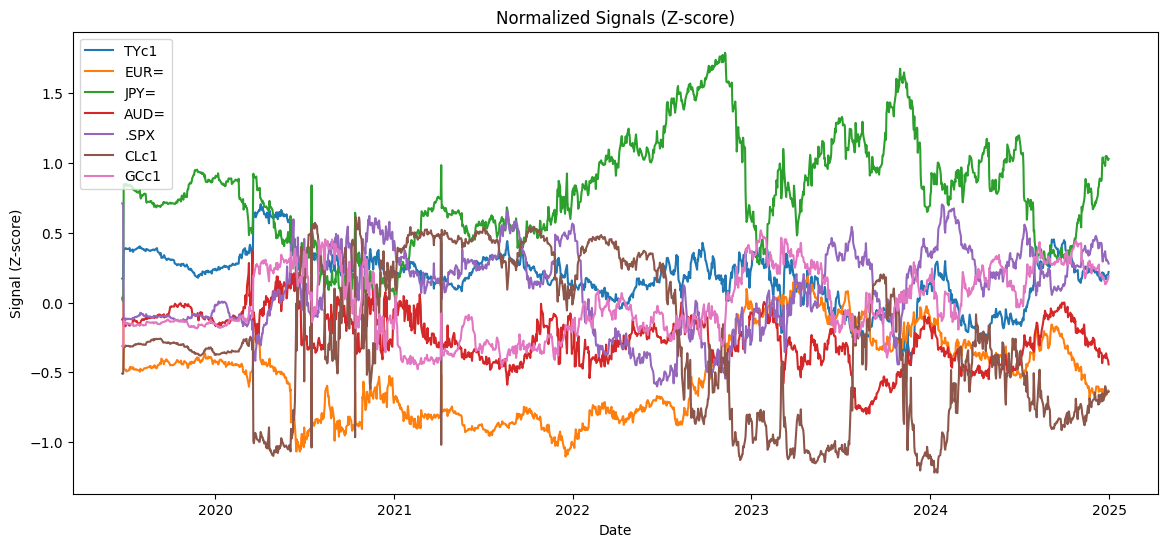

In [13]:
plt.figure(figsize=(14,6))
for ticker in combined_signal.columns:
    plt.plot(combined_signal.index, combined_signal[ticker], label=ticker)
plt.title("Normalized Signals (Z-score)")
plt.xlabel("Date")
plt.ylabel("Signal (Z-score)")
plt.legend()
plt.show()

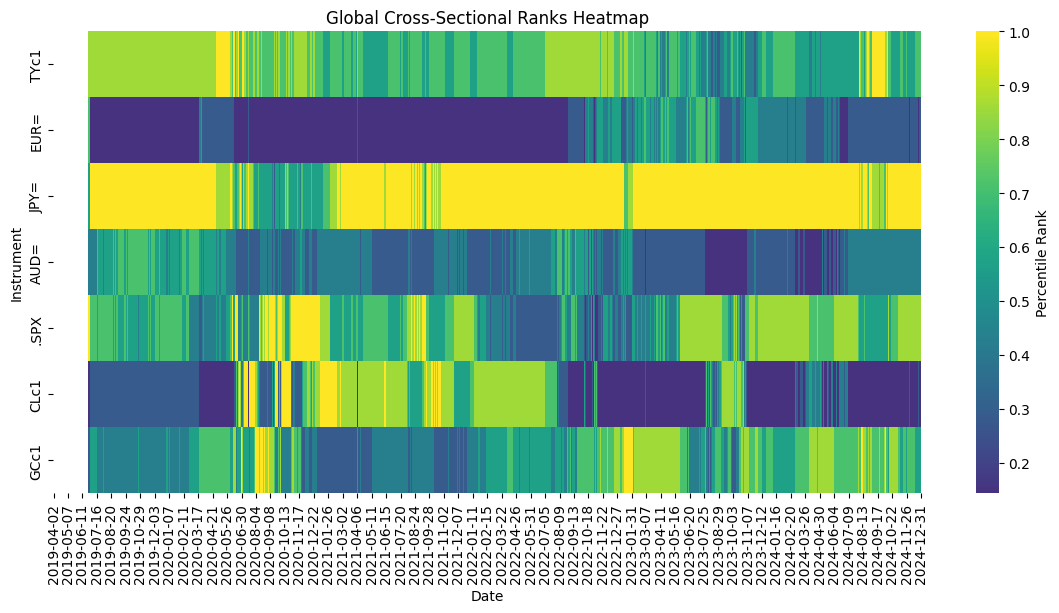

In [14]:
ranked = combined_signal.rank(axis=1, pct=True)
ranked_dates_only = ranked.copy()
ranked_dates_only.index = ranked_dates_only.index.date

plt.figure(figsize=(14,6))
sns.heatmap(ranked_dates_only.T, cmap='viridis', center=0.5, cbar_kws={'label': 'Percentile Rank'})
plt.title("Global Cross-Sectional Ranks Heatmap")
plt.xlabel("Date")
plt.ylabel("Instrument")
plt.show()


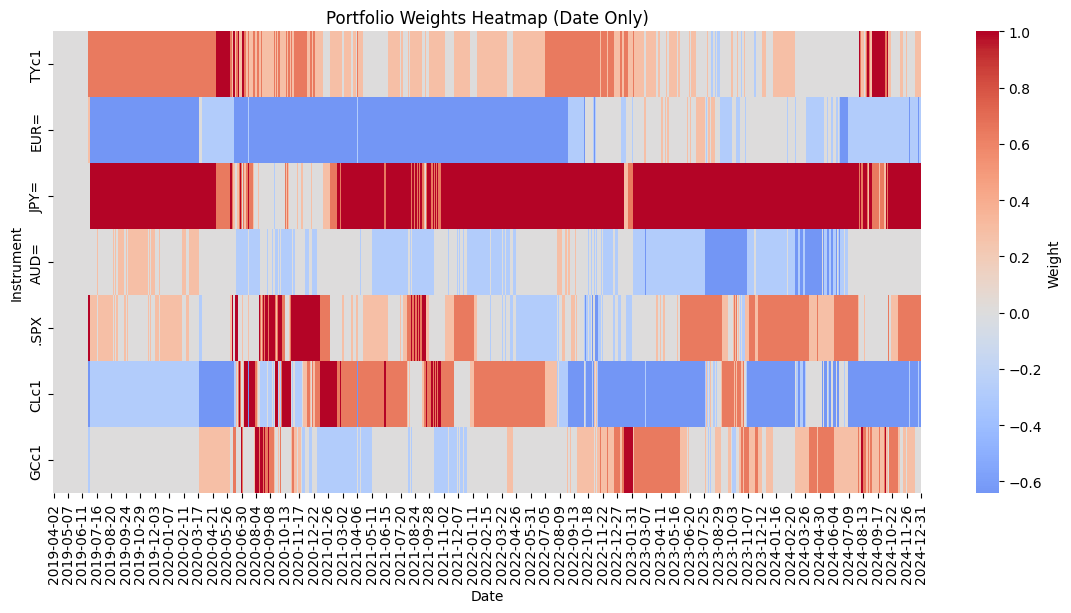

In [15]:


# Make a copy of index with date only
weights_dates_only = weights_raw.copy()
weights_dates_only.index = weights_dates_only.index.date

plt.figure(figsize=(14,6))
sns.heatmap(weights_dates_only.T, cmap='coolwarm', center=0, cbar_kws={'label': 'Weight'})
plt.title("Portfolio Weights Heatmap (Date Only)")
plt.xlabel("Date")
plt.ylabel("Instrument")
plt.show()



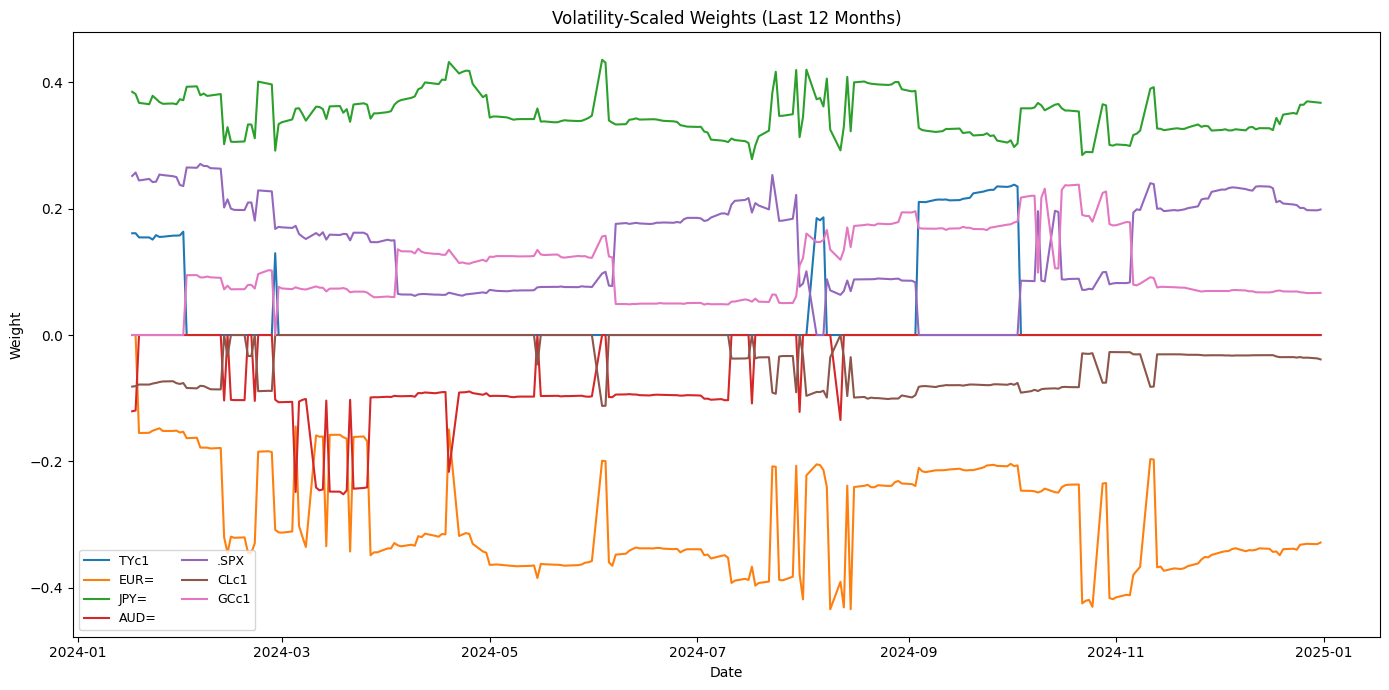

In [17]:
# ============================================================================
# Rolling snapshot (last N days only) 
# ============================================================================


N = 250  # last 1Y
recent = weights_vol_scaled.iloc[-N:]

plt.figure(figsize=(14, 7))

for col in recent.columns:
    plt.plot(recent.index, recent[col], label=col, linewidth=1.5)

plt.title("Volatility-Scaled Weights (Last 12 Months)")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

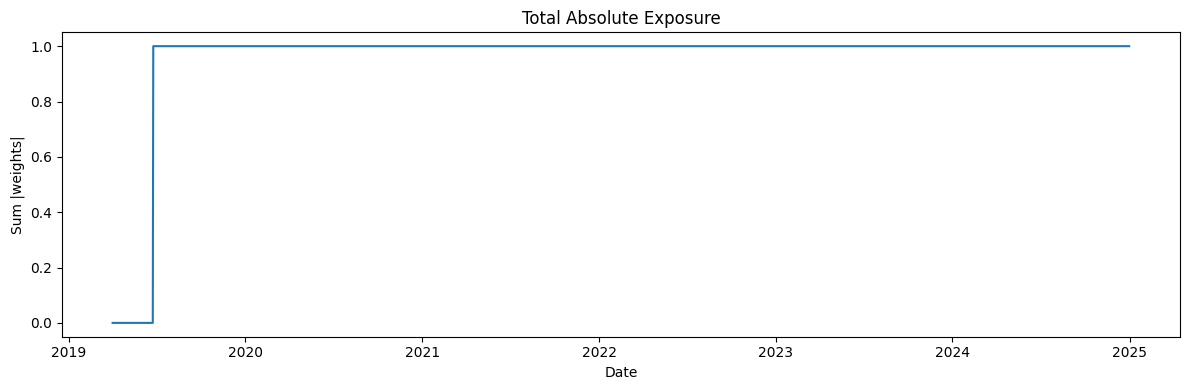

In [13]:
# ============================================================================
# Exposure sanity check 
# ============================================================================


abs_exposure = weights_vol_scaled.abs().sum(axis=1)

plt.figure(figsize=(12, 4))
plt.plot(abs_exposure.index, abs_exposure)
plt.title("Total Absolute Exposure")
plt.ylabel("Sum |weights|")
plt.xlabel("Date")
plt.tight_layout()
plt.show()